In [16]:
##########################################################
################ Load Packages / libraries ###############
##########################################################
import numpy as np
import pandas as pd
import pypyodbc as podbc
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

##########################################################
############## Configure notebook settings ############### 
##########################################################
np.set_printoptions(formatter={'float_kind':'{:f}'.format}) # To change scientific numbers to float
sns.set(rc={'figure.figsize':(8,6)}) # Increases the size of sns plots


In [17]:
##########################################################
########### Connect / Retrieve from SQL Server ########### 
##########################################################

con = podbc.connect("Driver={SQL Server Native Client 11.0};"
                     "Server=H510I\SQLEXPRESS;"
                     "Database=customers;"
                     "Trusted_Connection=yes;")

# Testing a query to confirm connection config
SQL_Query = pd.read_sql_query('''SELECT * FROM [dbo].[raw_data]''', con)
SQL_Query.head()

d:\CompSci\Projects\kmeans-clustering\.venv\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,id,age,gender,postcode,district,constituency,latitude,longitude,current_status,total_household_income,how_often_you_attend_entertaining_events_in_a_year,social_media,how_many_hours_are_you_willing_to_travel_to_attend_an_event,do_you_enjoy_adrenaline_rush_activities,are_food_areas_important_to_you,favourite_attraction,were_you_satisfied_with_the_last_event_you_attended_with_us,would_you_recommend_our_events_to_other_people,did_you_find_our_events_value_for_money
0,1,40-49,Female,AL9 7BN,Welwyn Hatfield,Welwyn Hatfield,51.727429,-0.183648,Married with children,"50,000 to 74,999",4 Times a Year,Up to 1 hour,3 hours,Entirely disagree,Entirely agree,Ice Bar,Somewhat agree,Somewhat Unlikely,Somewhat disagree
1,2,60-64,Male,AL7 1ZW,Welwyn Hatfield,Welwyn Hatfield,51.804482,-0.195898,Married with children,"35,000 to 49,999",3 Times a Year,Up to 1 hour,5 hours,Somewhat disagree,Entirely agree,Happy Rollercoaster,Mostly agree,Somewhat Likely,Entirely disagree
2,3,50-59,Male,AB4 5JX,Aberdeenshire,Banff and Buchan,57.692200,-2.022295,Married with children,"75,000 to 99,999",3 Times a Year,I don't spend any time at all,5 hours,Somewhat disagree,Somewhat agree,Happy Rollercoaster,Mostly agree,Mostly Unlikely,Entirely disagree
3,4,50-59,Female,B24 0DL,Birmingham,"Birmingham, Erdington",52.526595,-1.822211,Married without children,"35,000 to 49,999",1 Times a Year,Half a day,1 hour,Entirely agree,Neither agree nor disagree,Crazy rollercoaster ride,Somewhat agree,Somewhat Likely,Somewhat disagree
4,5,60-64,Male,E17 5QP,Waltham Forest,Walthamstow,51.593979,-0.040803,Married with children,"100,000 to 149,999",3 Times a Year,Up to 1 hour,6 hours plus,Mostly disagree,Neither agree nor disagree,Kids Playground,Entirely agree,Very Unlikely,Entirely agree


In [18]:
##########################################################
################ Dealing with null values ################ 
##########################################################
SQL_Query.isnull().sum()

# Deleting the NULL values
SQL_Query = SQL_Query.dropna(subset = ['total_household_income'])

# Printing the shape
print(SQL_Query.shape)

# Visualize the NULL observations
SQL_Query.isnull().sum()

(14778, 19)


id                                                             0
age                                                            0
gender                                                         0
postcode                                                       0
district                                                       0
constituency                                                   0
latitude                                                       0
longitude                                                      0
current_status                                                 0
total_household_income                                         0
how_often_you_attend_entertaining_events_in_a_year             0
social_media                                                   0
how_many_hours_are_you_willing_to_travel_to_attend_an_event    0
do_you_enjoy_adrenaline_rush_activities                        0
are_food_areas_important_to_you                                0
favourite_attraction     

In [19]:
##########################################################
######### Select features & check element counts ######### 
##########################################################
features = SQL_Query.columns.values
rem = ['id','district', 'constituency', 'postcode', 'latitude', 'longitude'] #remove location based features
features = np.setdiff1d(features, rem)

for column in SQL_Query:
    unique_vals = np.unique(SQL_Query[column])
    nr_values = len(unique_vals)
    print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature id :14778
The number of values for feature age :9
The number of values for feature gender :2
The number of values for feature postcode :14674
The number of values for feature district :225
The number of values for feature constituency :358
The number of values for feature latitude :13242
The number of values for feature longitude :13262
The number of values for feature current_status :8
The number of values for feature total_household_income :8
The number of values for feature how_often_you_attend_entertaining_events_in_a_year :5
The number of values for feature social_media :5
The number of values for feature how_many_hours_are_you_willing_to_travel_to_attend_an_event :7
The number of values for feature do_you_enjoy_adrenaline_rush_activities :7
The number of values for feature are_food_areas_important_to_you :7
The number of values for feature favourite_attraction :7
The number of values for feature were_you_satisfied_with_the_last_event_you_attended_

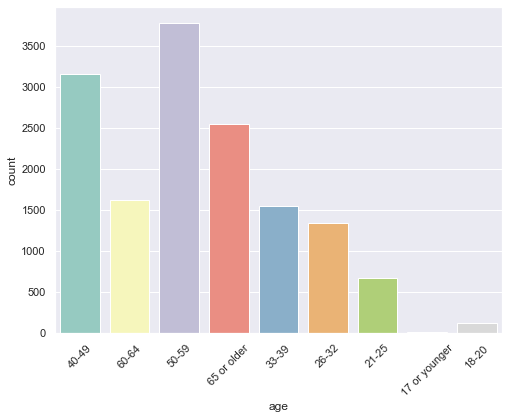

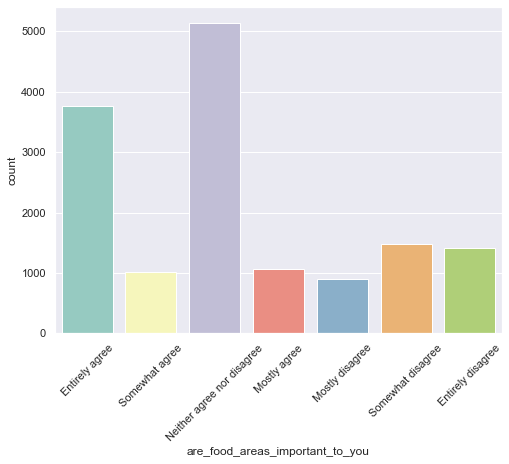

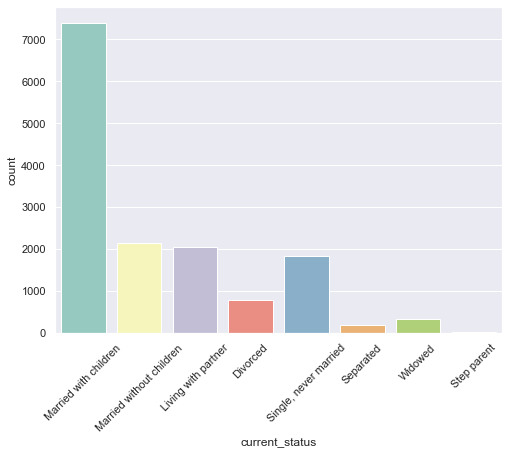

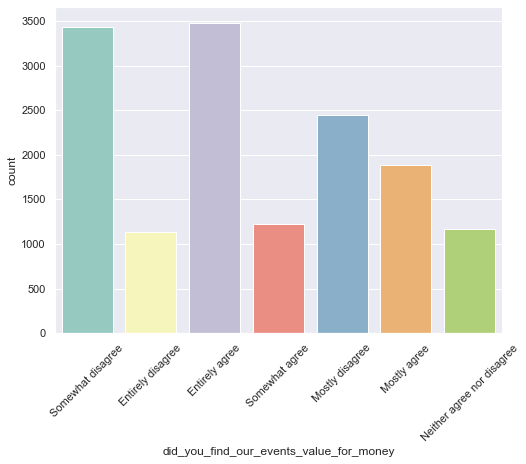

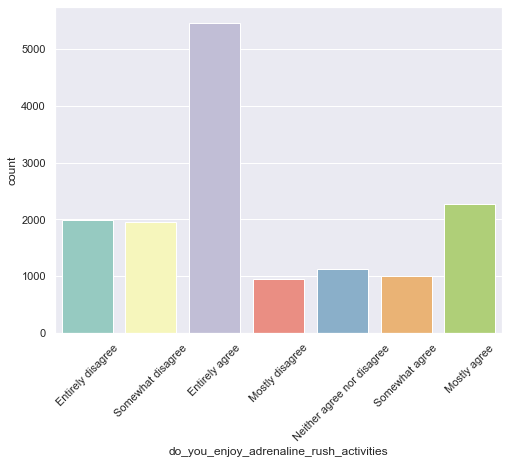

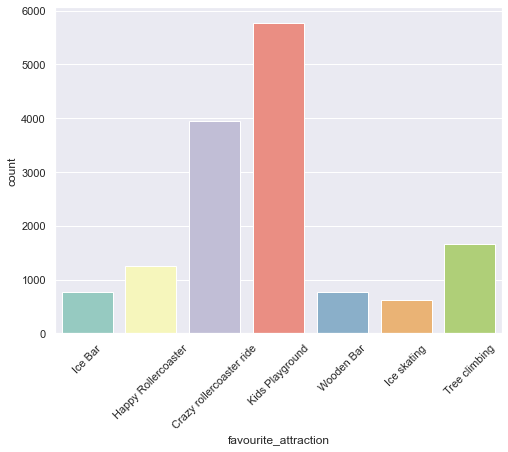

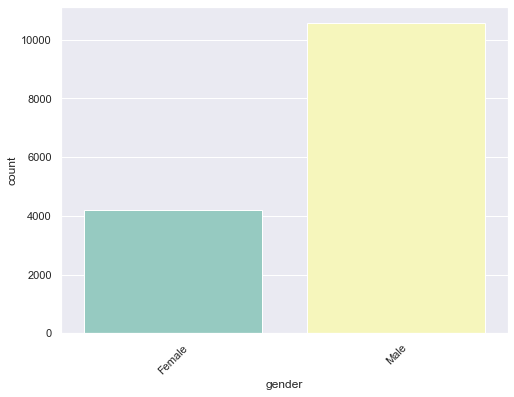

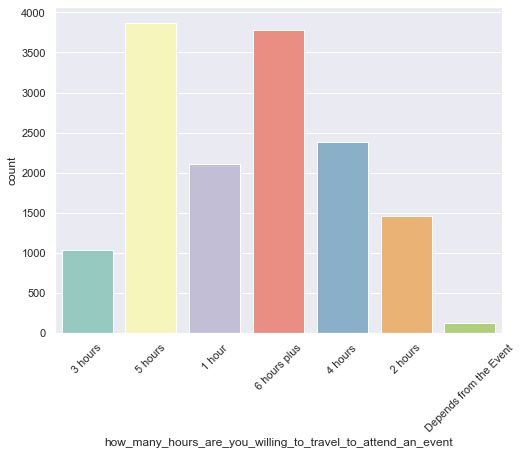

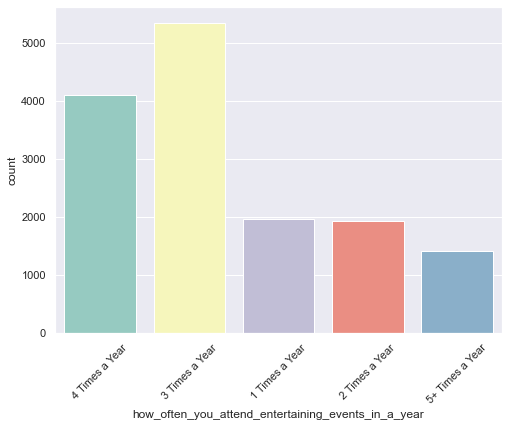

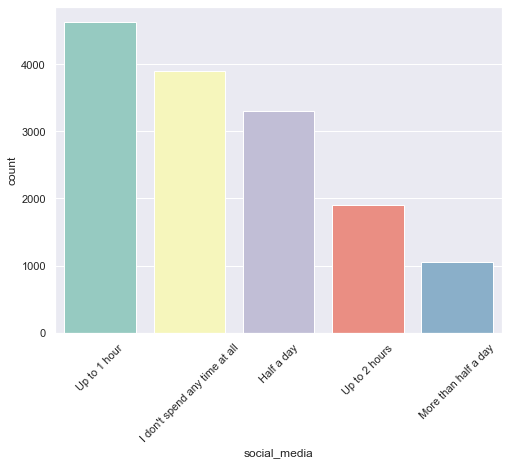

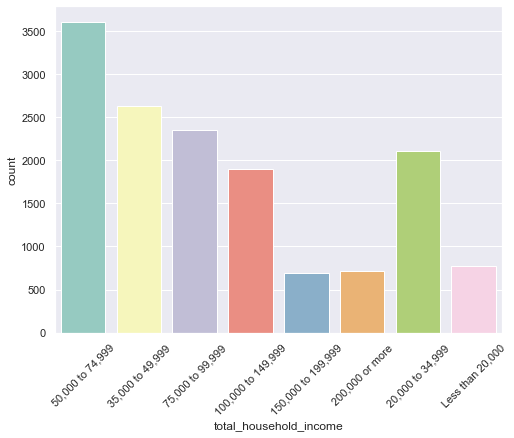

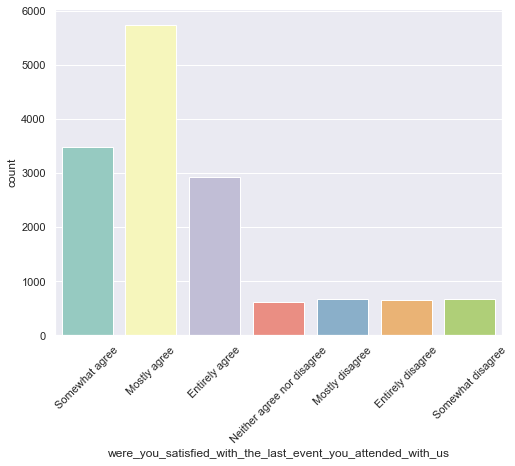

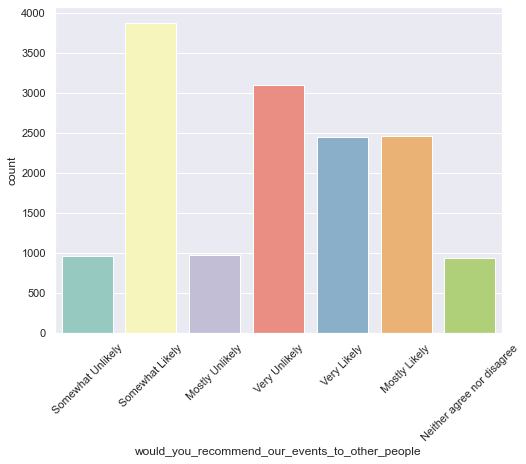

In [20]:
##########################################################
############ Visualising feature distributions ########### 
##########################################################
features = SQL_Query.columns.values
rem = ['id','district', 'constituency', 'postcode', 'latitude', 'longitude'] #remove location based features
features = np.setdiff1d(features, rem)
features

for f in features:
    sns.countplot(x = f, data = SQL_Query, palette = 'Set3')
    plt.xticks(rotation=45)
    plt.show()

In [21]:
##########################################################
######### Encode categorical variables to num. ########### 
##########################################################
# Original/raw data
print(f"Shape of original data: ", SQL_Query.shape)

# After feature removals
features_data = SQL_Query[features]
print(f"Shape of feature-removed data: ", features_data.shape)

# Encoded data shape
df = pd.get_dummies(features_data, columns = features)
print(f"Shape of encoded data: ", df.shape)

df.head()

Shape of original data:  (14778, 19)
Shape of feature-removed data:  (14778, 13)
Shape of encoded data:  (14778, 86)


,age_17 or younger,age_18-20,age_21-25,age_26-32,age_33-39,age_40-49,age_50-59,age_60-64,age_65 or older,are_food_areas_important_to_you_Entirely agree,...,were_you_satisfied_with_the_last_event_you_attended_with_us_Neither agree nor disagree,were_you_satisfied_with_the_last_event_you_attended_with_us_Somewhat agree,were_you_satisfied_with_the_last_event_you_attended_with_us_Somewhat disagree,would_you_recommend_our_events_to_other_people_Mostly Likely,would_you_recommend_our_events_to_other_people_Mostly Unlikely,would_you_recommend_our_events_to_other_people_Neither agree nor disagree,would_you_recommend_our_events_to_other_people_Somewhat Likely,would_you_recommend_our_events_to_other_people_Somewhat Unlikely,would_you_recommend_our_events_to_other_people_Very Likely,would_you_recommend_our_events_to_other_people_Very Unlikely
0,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


At 2 clusters, the intertia is: 125619.02972065713
At 3 clusters, the intertia is: 114905.38346130148
At 4 clusters, the intertia is: 106337.17594801621
At 5 clusters, the intertia is: 100865.1729715391
At 6 clusters, the intertia is: 96432.61527743531
At 7 clusters, the intertia is: 93814.49897631719
At 8 clusters, the intertia is: 91590.32870109123
At 9 clusters, the intertia is: 89725.51400872343
At 10 clusters, the intertia is: 88467.37661887112
At 11 clusters, the intertia is: 87556.04783513471
At 12 clusters, the intertia is: 86587.76029885457
At 13 clusters, the intertia is: 85980.06591463836
At 14 clusters, the intertia is: 85052.82853329318
At 15 clusters, the intertia is: 84254.01077256388


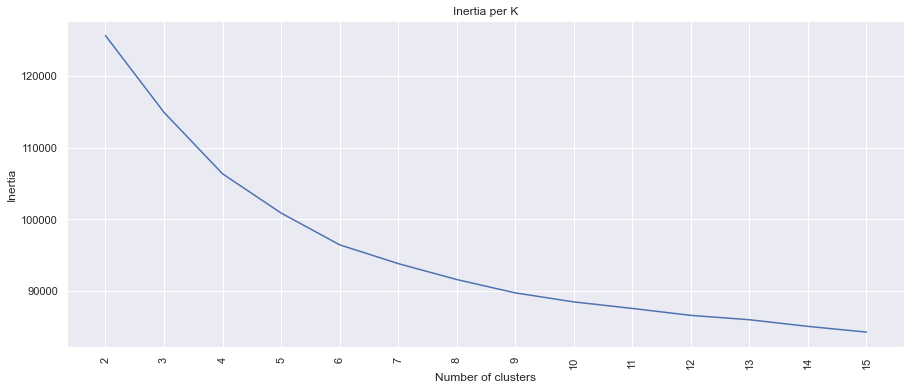

In [22]:
##########################################################
############## K-Means Clustering Training ############### 
##########################################################
X_train = df.values
no_of_clusters = range(2,16) 
inertia = [] # the within-cluster sum of squares 

# Running K means with multible Ks
for f in no_of_clusters:
    kmeans = KMeans(n_clusters=f, random_state=100)
    kmeans = kmeans.fit(X_train)
    u = kmeans.inertia_
    inertia.append(u)
    print("At", f, "clusters, the intertia is:", u)
    
# Creating the scree plot for intertia
fig, (ax1) = plt.subplots(1, figsize=(15,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title("Inertia per K")
plt.savefig('inertia_per_k.png')

In [23]:
##########################################################
########### K-Means Clustering Results (k=5) ############# 
##########################################################
# # Running K means on 5 clusters
kmeans = KMeans(n_clusters=5, random_state=2)
kmeans = kmeans.fit(X_train)
kmeans.labels_

# "predictions" for new data
predictions = kmeans.predict(X_train)

# calculating the Counts of the cluster
unique, counts = np.unique(predictions, return_counts=True)
counts = counts.reshape(1,5)

# Creating a dataframe for cluster counts
counts_df = pd.DataFrame(counts, columns = ["Cluster 1","Cluster 2","Cluster 3", "Cluster 4","Cluster 5"])

# save to csv
counts_df.to_csv('counts_df.csv')
counts_df.head()

Explained variance ratio (first two components): [0.167356 0.078177]


<Figure size 576x432 with 0 Axes>

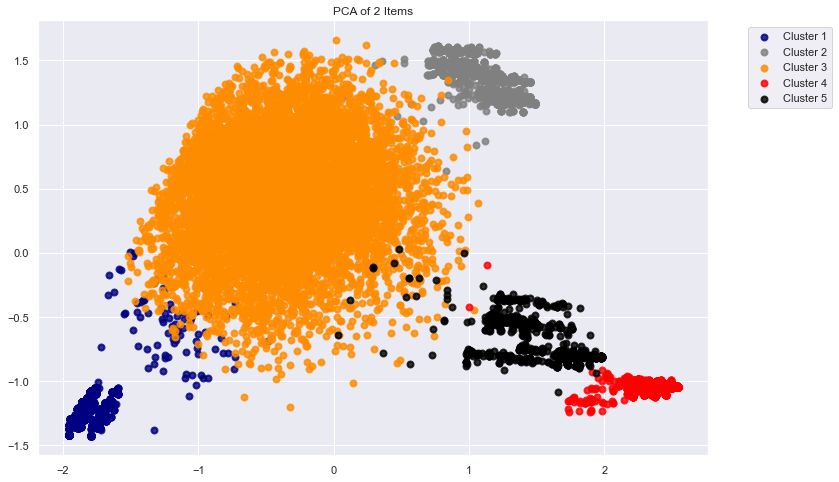

In [26]:
##########################################################
#################### Instantiate PCA ##################### 
##########################################################
# Instantiate PCA to visualize the data
X = X_train
y_num = kmeans.predict(X_train)
target_names = ["Cluster 1","Cluster 2","Cluster 3", "Cluster 4","Cluster 5"]
pca = PCA(n_components=2, random_state = 100)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))

# Plotting the data
plt.figure()
plt.figure(figsize=(12,8))
colors = ['navy', 'grey', 'darkorange', 'red', 'black']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], target_names):
    plt.scatter(X_r[y_num == i, 0], X_r[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
    
plt.legend(loc='best', shadow=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title('PCA of 2 Items')
plt.show()

In [29]:
# Trying with Dimentionality reduction and then Kmeans
n_components = X.shape[1]

# Running PCA with all components
pca = PCA(n_components=n_components, random_state = 100)
X_r = pca.fit(X).transform(X)

# Calculating the 95% Variance
total_variance = sum(pca.explained_variance_)
print("Total Variance in our dataset is: ", total_variance)
var_95 = total_variance * 0.95
print("The 95% variance we want to have is: ", var_95)

Total Variance in our dataset is:  9.789277508428574
The 95% variance we want to have is:  9.299813633007146
